## Create dataset

We will explore a dataset cointaing for each country a series of values such as populaiton count and gdp collected from https://data.worldbank.org

In [14]:
import pandas as pd
import numpy as np
import os

In [2]:
# read the files containing the various datasets

population = pd.read_csv('API_SP.POP.TOTL_DS2_en_csv_v2_247892.csv', skiprows=4)
dept = pd.read_csv('API_FI.RES.TOTL.DT.ZS_DS2_en_csv_v2_256118.csv', skiprows=4)
gdp = pd.read_csv('API_NY.GDP.MKTP.CD_DS2_en_csv_v2_247793.csv', skiprows=4)
edu = pd.read_csv('API_SE.PRM.CMPT.ZS_DS2_en_csv_v2_249118.csv', skiprows=4)
health_expenditure = pd.read_csv('API_SH.XPD.CHEX.PC.CD_DS2_en_csv_v2_252116.csv', skiprows=4)
employment_to_pop_ratio = pd.read_csv('API_SL.EMP.TOTL.SP.ZS_DS2_en_csv_v2_256109.csv', skiprows=4)

In [3]:
dfs = [population, gdp, health_expenditure, employment_to_pop_ratio]

In [4]:
import math

data = {}

for row in range(dfs[0].shape[0]):    
    data_for_country = []
    
    for year in range(1960, 2019):
        
        data_country_year = [year]
        
        for df in dfs:
            data_country_year.append(df.iloc[row][str(year)])
            
        if not any([math.isnan(x) for x in data_country_year]):
            data_for_country.append(data_country_year)
    
    if len(data_for_country) >= 5:
        data[dfs[0].iloc[row]['Country Name']] = data_for_country

In [7]:
maximum_length = np.max([len(v) for v in data.values()])

number_of_features = len(next(iter(data.values()))[0])

In [8]:
countries = list()

dataset = list()

lengths = list()

for k, v in data.items():
    countries.append(k)
    lengths.append(len(v))
    # add a random value that does not worsen the scaler's performance
    dataset.append(v + [next(iter(data.values()))[0] for _ in range(maximum_length - len(v))])
    
dataset = np.array(dataset)
lengths = np.array(lengths)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
dataset = scaler.fit_transform(dataset.reshape(-1, maximum_length * number_of_features))
dataset = dataset.reshape([-1, maximum_length, number_of_features])

In [10]:
from sklearn.model_selection import train_test_split

countries_train, countries_test, dataset_train, dataset_test, lengths_train, lengths_test = \
    train_test_split(countries, dataset, lengths, test_size=0.2, random_state=42)

In [64]:
dataset_train.shape

(176, 17, 5)

dataset_train contains for each of the 176 countries a total of 5 values (including time) for 17 time points (padded for all countries at the length 17)

## Create the model

In [11]:
import numpy as np
import tensorflow as tf

batch_size = 32
hidden_size = 25

# HARD CODED!
latent_space_size = 3
assert(latent_space_size == 3)

/home/sotiris/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sotiris/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sotiris/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sotiris/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

In [52]:
def create_graph():
    tf_lengths = tf.placeholder(dtype=tf.int32, shape=[None])
    # 0 position of tf_inputs contains the time
    tf_inputs = tf.placeholder(dtype=tf.float32, shape=[None, maximum_length, number_of_features])

    cell = tf.nn.rnn_cell.GRUCell(hidden_size)

    outputs, states = tf.nn.dynamic_rnn(cell=cell, dtype=tf.float32, sequence_length=tf_lengths, inputs=tf_inputs)

    x = tf.layers.dense(states, (latent_space_size + 1) * 5, activation=tf.nn.relu)
    tf_latent_space = tf.layers.dense(x, latent_space_size + 1)

    inputs_per_time_step = tf.transpose(tf_inputs, [1, 0, 2])

    def get_trajectory(input_):
        temp = tf.map_fn(lambda x: [tf.math.exp(x[1][0]) * (x[0][0] - x[1][1]),
                                    x[1][2], x[1][3]], 
                         (input_, tf_latent_space), 
                         dtype=[tf.float32, tf.float32, tf.float32])

        return tf.transpose(temp, [1, 0])

    trajectories = tf.map_fn(get_trajectory, inputs_per_time_step, dtype=[])
    trajectories = tf.transpose(trajectories, [1, 0, 2])

    trajectories = tf.reshape(trajectories, [-1, latent_space_size])

    reconstruction = tf.layers.dense(trajectories, latent_space_size * 5, activation=tf.nn.relu)
    reconstruction = tf.layers.dense(reconstruction, number_of_features)

    reconstruction = tf.reshape(reconstruction, [-1, maximum_length, number_of_features])
    
    return tf_lengths, tf_inputs, reconstruction, tf_latent_space

### Train the model

In [67]:
from sklearn.utils import shuffle

lr = 3e-3
n_epochs = 200
log_path = "saved_models"
decay_steps = (len(lengths_train) / batch_size) * 10
decay = 0.95

try: 
    os.rmdir(log_path) 
    print('Deleted existing log path folder')
except OSError:
    ;


def get_batches(iterable, batch_size=8, do_shuffle=True):
    if do_shuffle:
        iterable = shuffle(iterable)

    length = len(iterable)
    for ndx in range(0, length, batch_size):
        iterable_batch = iterable[ndx: min(ndx + batch_size, length)]
        yield iterable_batch

In [68]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        tf_lengths, tf_inputs, reconstruction, tf_latent_space = create_graph()
        
        # remove the time axis for the reconstruction error
        error = tf.slice(tf_inputs - reconstruction, [0, 0, 1], [-1, -1, number_of_features - 1])
        
        # remove padded sequences from reconstruction error
        mask = tf.sequence_mask(tf_lengths, maxlen=maximum_length)
        mask = tf.expand_dims(mask, 2)
        mask = tf.tile(mask, [1, 1, number_of_features - 1])
        mask = tf.cast(mask, tf.float32)
        error = error * mask
        
        tf_loss_error = tf.reduce_sum(tf.reduce_sum(tf.square(error), 2))
        
        # TODO how to correctly estimate mean and variance for eta and tau
        etas = tf.gather(tf.transpose(tf_latent_space), 0)
        mean, var = tf.nn.moments(etas, axes=0)
        etas = tf.square((etas - mean)) / var

        taus = tf.gather(tf.transpose(tf_latent_space), 1)
        mean, var = tf.nn.moments(taus, axes=0)
        taus = tf.square((taus - mean)) / var

        betas = tf.gather(tf.transpose(tf_latent_space), [2,3])
        betas = tf.square(betas)
        
        # this loss depends on the number of samples per batch
        tf_loss_reg = tf.reduce_sum(etas) + tf.reduce_sum(taus) + tf.reduce_sum(betas)
        
        
        # TODO make this a placeholder
        sigma = 1
        
        tf_loss = tf_loss_error / sigma + tf_loss_reg
        
        global_step = tf.Variable(1, name='global_step', trainable=False)
        
        learning_rate = tf.Variable(lr, trainable=False, dtype=tf.float32, name="learning_rate")
        learning_rate = tf.train.exponential_decay(learning_rate, global_step, decay_steps, decay)
        
        # Gradients and update operation for training the model.
        opt = tf.train.AdamOptimizer(learning_rate)
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

        with tf.control_dependencies(update_ops):
            # Update all the trainable parameters
            train_step = opt.minimize(tf_loss, global_step=global_step)
    
        saver = tf.train.Saver(max_to_keep=1)

        sess.run(tf.global_variables_initializer())
        
        for epoch in range(n_epochs):
            total_loss_train = 0
            for indices in get_batches(list(range(len(lengths_train))), batch_size=batch_size):
                lens = lengths_train[indices]
                data_batch = dataset_train[indices]
                
                _, loss, _ = sess.run([train_step, tf_loss, global_step],
                                            feed_dict={tf_lengths: lens, tf_inputs: data_batch})
                
                num_samples = len(indices)
                total_loss_train += loss
                
            total_loss_train /= len(lengths_train)

            total_loss_test = 0
            for indices in get_batches(list(range(len(lengths_test))), batch_size=batch_size):
                lens = lengths_test[indices]
                data_batch = dataset_test[indices]
                
                loss = sess.run(tf_loss, feed_dict={tf_lengths: lens, tf_inputs: data_batch})
                
                num_samples = len(indices)
                total_loss_test += loss
                
            total_loss_test /= len(lengths_test)
     
            if (epoch + 1) % 10 == 0:
                print('At epoch {0:3d} training loss: {1:.3f} and test loss: {2:.3f}' \
                      .format(epoch + 1, total_loss_train, total_loss_test))
        
        saver.save(sess, os.path.join(log_path, "model"))

/home/sotiris/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/sotiris/.local/lib/python3.7/site-packages/tensorflow/python/ops/gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


At epoch  10 training loss: 8.561 and test loss: 6.624
At epoch  20 training loss: 7.318 and test loss: 5.497
At epoch  30 training loss: 5.007 and test loss: 5.075
At epoch  40 training loss: 5.408 and test loss: 4.949
At epoch  50 training loss: 4.506 and test loss: 4.698
At epoch  60 training loss: 4.498 and test loss: 4.642
At epoch  70 training loss: 4.360 and test loss: 4.706
At epoch  80 training loss: 4.066 and test loss: 4.512
At epoch  90 training loss: 3.938 and test loss: 4.613
At epoch 100 training loss: 3.941 and test loss: 4.644
At epoch 110 training loss: 3.856 and test loss: 4.464
At epoch 120 training loss: 3.794 and test loss: 4.628
At epoch 130 training loss: 4.114 and test loss: 4.999
At epoch 140 training loss: 3.770 and test loss: 4.570
At epoch 150 training loss: 3.714 and test loss: 4.530
At epoch 160 training loss: 3.702 and test loss: 4.678
At epoch 170 training loss: 3.663 and test loss: 4.482
At epoch 180 training loss: 3.784 and test loss: 4.716
At epoch 1

In [69]:
with tf.Graph().as_default():
    with tf.Session() as sess:
        tf_lengths, tf_inputs, reconstruction, _ = create_graph()
        
        saver = tf.train.Saver()
        saver.restore(sess, tf.train.latest_checkpoint(log_path))
        
        samples = []
        for indices in get_batches(list(range(len(lengths_test))), batch_size=batch_size):
            lens = lengths_test[indices]
            data_batch = dataset_test[indices]

            recon = sess.run(reconstruction, feed_dict={tf_lengths: lens, tf_inputs: data_batch})

            samples.append(recon)
            
samples = np.concatenate(samples, axis=0)

INFO:tensorflow:Restoring parameters from saved_models/model


In [70]:
original_data = scaler.inverse_transform(dataset_test.reshape(-1, maximum_length * number_of_features))
original_data = original_data.reshape(-1, maximum_length, number_of_features)

recon_data = scaler.inverse_transform(samples.reshape(-1, maximum_length * number_of_features))
recon_data = recon_data.reshape(-1, maximum_length, number_of_features)

In [71]:
test = original_data[:, :, 1:]
recon_data = recon_data[:, :, 1:]

In [72]:
print(test.shape)
print(recon_data.shape)

(44, 17, 4)
(44, 17, 4)


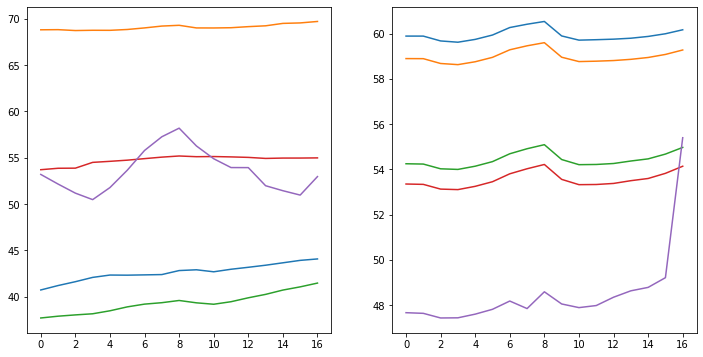

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import rcParams
%matplotlib inline


rcParams['figure.figsize'] = 12, 6


plt.subplot(121)

indices = [32, 34, 14, 35, 30]
test_i = 3

for i in indices:
    plt.plot(test[i, :lengths_test[i], test_i])
    
plt.subplot(122)

for i in indices:
    plt.plot(recon_data[i, :lengths_test[i], test_i])

plt.show()

For the above graph I included employment ratios only. Data is not well captured. Maybe it has something to do with the huge discrepancies in values for other features? (such as population between different countries)